In [1]:
import numpy as np
import pandas as pd 

# IMPORT LIBRARY

In [5]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [17]:
if tf.test.is_gpu_available():
    print("TensorFlow is using GPU")
else:
    print("TensorFlow is using CPU")

TensorFlow is using CPU


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam
from imblearn.over_sampling import SMOTE

# READ DATASETS

In [28]:
df = pd.read_excel('bank-full.xlsx')

In [29]:
df.tail(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


# Cek Missing Value

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [33]:
print(df.isnull().sum())
print('')

print(df[df.duplicated()])

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Empty DataFrame
Columns: [age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome, y]
Index: []


# Preprocessing Data

> **One-Hot Encode for the features selected**

In [34]:
label_encoder = LabelEncoder()
binary_columns = ['default', 'housing', 'loan', 'y']

# Encoding kolom-kolom kategori
for column in binary_columns:
    df[column] = label_encoder.fit_transform(df[column])
categorical_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

data = df_encoded.astype(int)

In [35]:
data.head(5)

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,261,1,-1,0,...,0,0,0,1,0,0,0,0,0,1
1,44,0,29,1,0,5,151,1,-1,0,...,0,0,0,1,0,0,0,0,0,1
2,33,0,2,1,1,5,76,1,-1,0,...,0,0,0,1,0,0,0,0,0,1
3,47,0,1506,1,0,5,92,1,-1,0,...,0,0,0,1,0,0,0,0,0,1
4,33,0,1,0,0,5,198,1,-1,0,...,0,0,0,1,0,0,0,0,0,1


In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  45211 non-null  int64
 1   default              45211 non-null  int64
 2   balance              45211 non-null  int64
 3   housing              45211 non-null  int64
 4   loan                 45211 non-null  int64
 5   day                  45211 non-null  int64
 6   duration             45211 non-null  int64
 7   campaign             45211 non-null  int64
 8   pdays                45211 non-null  int64
 9   previous             45211 non-null  int64
 10  y                    45211 non-null  int64
 11  job_blue-collar      45211 non-null  int64
 12  job_entrepreneur     45211 non-null  int64
 13  job_housemaid        45211 non-null  int64
 14  job_management       45211 non-null  int64
 15  job_retired          45211 non-null  int64
 16  job_self-employed    4

# Select Features And Target

In [36]:
X = data.drop(columns=['y'])
y = data['y']

> **check whether the data is balanced or not**

In [37]:
label_counts = data['y'].value_counts()
print(label_counts)

y
0    39922
1     5289
Name: count, dtype: int64


# SMOTE DATA

In [38]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

> **StandardScaler for numeric features**

In [39]:
scaler = StandardScaler()
columns_to_standardize = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
X_resampled[columns_to_standardize] = scaler.fit_transform(X_resampled[columns_to_standardize])

# Split Data

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Build Up Neural Network Model

In [41]:
model = Sequential([
    Dense(64, input_dim=X_train_final.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model dengan optimizer SGD
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

In [42]:
history = model.fit(X_train_final.values, y_train_final.values, 
                    epochs=100, 
                    validation_data=(X_val.values, y_val.values), 
                    batch_size=32, 
                    verbose=2)

Epoch 1/100
1597/1597 - 6s - 4ms/step - accuracy: 0.6286 - loss: 0.6686 - val_accuracy: 0.7774 - val_loss: 0.6209
Epoch 2/100
1597/1597 - 5s - 3ms/step - accuracy: 0.8056 - loss: 0.5766 - val_accuracy: 0.8246 - val_loss: 0.5277
Epoch 3/100
1597/1597 - 5s - 3ms/step - accuracy: 0.8362 - loss: 0.4901 - val_accuracy: 0.8506 - val_loss: 0.4507
Epoch 4/100
1597/1597 - 5s - 3ms/step - accuracy: 0.8594 - loss: 0.4233 - val_accuracy: 0.8723 - val_loss: 0.3927
Epoch 5/100
1597/1597 - 5s - 3ms/step - accuracy: 0.8774 - loss: 0.3727 - val_accuracy: 0.8877 - val_loss: 0.3487
Epoch 6/100
1597/1597 - 4s - 3ms/step - accuracy: 0.8896 - loss: 0.3343 - val_accuracy: 0.8973 - val_loss: 0.3157
Epoch 7/100
1597/1597 - 5s - 3ms/step - accuracy: 0.8979 - loss: 0.3055 - val_accuracy: 0.9048 - val_loss: 0.2910
Epoch 8/100
1597/1597 - 5s - 3ms/step - accuracy: 0.9034 - loss: 0.2839 - val_accuracy: 0.9097 - val_loss: 0.2724
Epoch 9/100
1597/1597 - 5s - 3ms/step - accuracy: 0.9075 - loss: 0.2673 - val_accuracy: 

Epoch 73/100
1597/1597 - 5s - 3ms/step - accuracy: 0.9336 - loss: 0.1611 - val_accuracy: 0.9341 - val_loss: 0.1640
Epoch 74/100
1597/1597 - 5s - 3ms/step - accuracy: 0.9338 - loss: 0.1608 - val_accuracy: 0.9343 - val_loss: 0.1638
Epoch 75/100
1597/1597 - 5s - 3ms/step - accuracy: 0.9336 - loss: 0.1606 - val_accuracy: 0.9344 - val_loss: 0.1637
Epoch 76/100
1597/1597 - 5s - 3ms/step - accuracy: 0.9339 - loss: 0.1603 - val_accuracy: 0.9346 - val_loss: 0.1635
Epoch 77/100
1597/1597 - 5s - 3ms/step - accuracy: 0.9337 - loss: 0.1601 - val_accuracy: 0.9346 - val_loss: 0.1633
Epoch 78/100
1597/1597 - 5s - 3ms/step - accuracy: 0.9339 - loss: 0.1598 - val_accuracy: 0.9341 - val_loss: 0.1631
Epoch 79/100
1597/1597 - 5s - 3ms/step - accuracy: 0.9341 - loss: 0.1596 - val_accuracy: 0.9342 - val_loss: 0.1631
Epoch 80/100
1597/1597 - 5s - 3ms/step - accuracy: 0.9339 - loss: 0.1594 - val_accuracy: 0.9340 - val_loss: 0.1628
Epoch 81/100
1597/1597 - 5s - 3ms/step - accuracy: 0.9339 - loss: 0.1592 - val_a

# Learning Curve To Check Overfit or Underfit

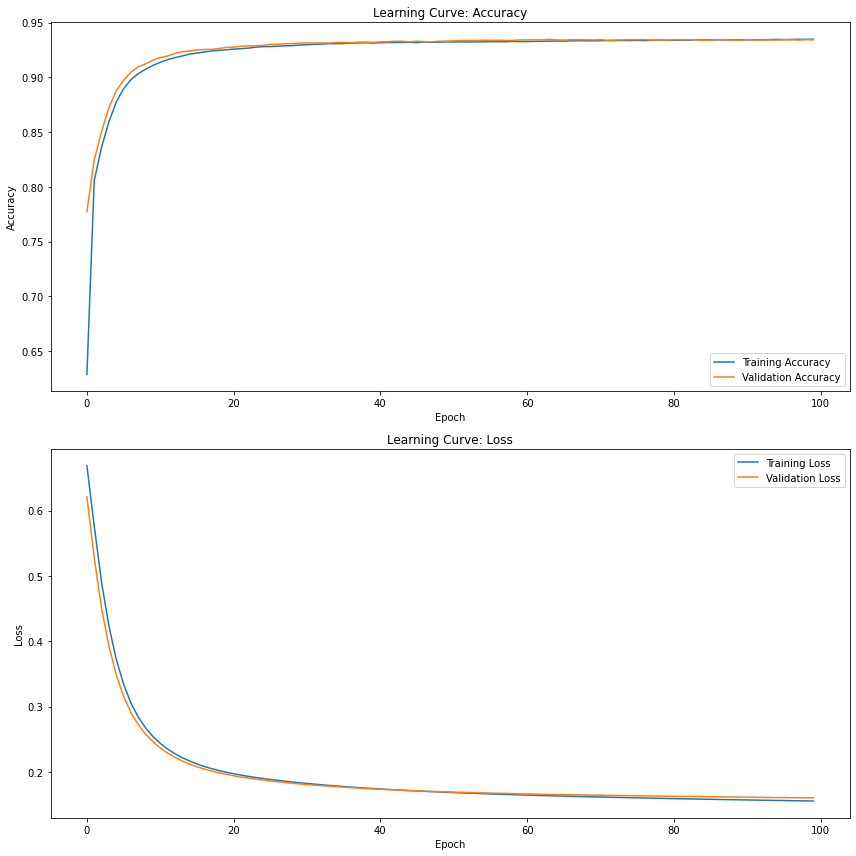

In [43]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Matrix Confusion & Classification Report

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


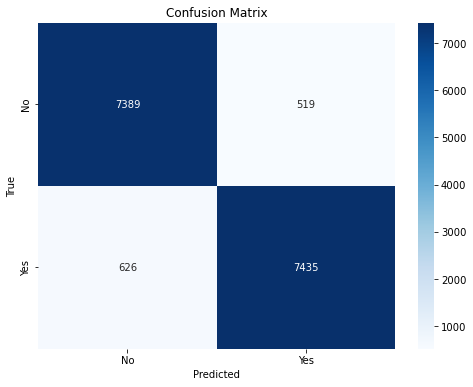

In [44]:
y_pred = (model.predict(X_test.values) > 0.5).astype("int32")  # Mengonversi probabilitas ke biner

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [45]:
class_report = classification_report(y_test, y_pred, target_names=['No', 'Yes'])
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

          No       0.92      0.93      0.93      7908
         Yes       0.93      0.92      0.93      8061

    accuracy                           0.93     15969
   macro avg       0.93      0.93      0.93     15969
weighted avg       0.93      0.93      0.93     15969



In [79]:
import pickle

In [80]:
with open('bank.pkl', 'wb') as file:
    pickle.dump(model, file)

In [81]:
with open('bank.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [82]:
predictions = loaded_model.predict(X_test)

# If it's a classification model, you might want to round or argmax predictions
# For example, for binary classification:
predicted_classes = (predictions > 0.5).astype("int32")

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [83]:
loaded_model.predict(X_test)

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 994us/step


array([[0.99897027],
       [0.9899598 ],
       [0.99546903],
       ...,
       [0.08636249],
       [0.9991879 ],
       [0.9968851 ]], dtype=float32)

In [84]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15969 entries, 72809 to 47389
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  15969 non-null  float64
 1   default              15969 non-null  int64  
 2   balance              15969 non-null  float64
 3   housing              15969 non-null  int64  
 4   loan                 15969 non-null  int64  
 5   day                  15969 non-null  float64
 6   duration             15969 non-null  float64
 7   campaign             15969 non-null  float64
 8   pdays                15969 non-null  float64
 9   previous             15969 non-null  float64
 10  job_blue-collar      15969 non-null  int64  
 11  job_entrepreneur     15969 non-null  int64  
 12  job_housemaid        15969 non-null  int64  
 13  job_management       15969 non-null  int64  
 14  job_retired          15969 non-null  int64  
 15  job_self-employed    15969 non-null  

In [85]:
y_test.head()

72809    1
71061    1
57176    1
40165    0
71998    1
Name: y, dtype: int64

In [86]:
X_test.head(1)

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
72809,-0.90541,0,-0.081431,0,0,-0.166062,0.757251,-0.525191,-0.488358,-0.33571,...,0,0,0,0,0,0,0,0,0,1


In [91]:
loaded_model.predict(0.19117647, 0.43333333, 0.33921623, 0.        , 0.50751343,        0.42585668,0,.        , 0.        , 0.        , 1.        ,        0.        , 0.        , 0.        , 0.        , 0.        ,        0.        , 1.        , 0.        , 0.        , 1.        ,        0.        , 0.        , 0.        , 0.        , 1.        ,        0.        , 0.        , 0.        , 0.        , 0.        ,        0.        , 0.        , 0.        , 0.        , 0.        ,       0.        , 0.        , 0.        ,        0.        , 0.    )

SyntaxError: invalid syntax (3355273751.py, line 1)

In [93]:
da=np.array(X_test)

In [94]:
da[1:2]

array([[-0.63097978,  0.        , -0.2774579 ,  0.        ,  0.        ,
        -0.1660623 , -0.27694185,  0.25297346,  1.25408341,  0.10945032,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ]])